In [ ]:
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from pprint import pprint
import keras
import sklearn
import tensorflow as tf
tf.__version__

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Import the data

In [3]:
def load_dico(path,key_int=False,print_me=False):
    with open(path) as f:
        dico_str = json.loads(json.load(f))

    if key_int:
        conv_key=lambda k:int(k)
    else:
        conv_key=lambda k:k

    dico={conv_key(k):v for k,v in dico_str.items()}

    if print_me:
        print(dico)

    return dico

In [4]:
class classCLASS:

    def __init__(self,id,name,behaviors,sampling_weight=1,loss_weight=1):
        self.id=id
        self.name=name
        self.behaviors=behaviors
        self.sampling_weight=sampling_weight
        self.loss_weight=loss_weight

In [5]:
""" a dictionary to store all the information """
memo=pd.Series()

In [6]:
#Path to the folder containing the Hawksbill dataset downloaded from Zenodo
Folder_data="~/Hawksbill"

In [7]:
#Split the data into training/validation/testing dataset based on the individuals
NAMES_TRAIN=memo["NAMES_TRAIN"]=[
    'CC-09-80_08-03-2023_1',
    'CC-09-80_08-03-2023_2',
    'CC-09-72_02-11-2022_1',
    'CC-09-80_16-05-2023_1',
    'CC-09-80_16-05-2023_2']

NAMES_VAL=memo["NAMES_VAL"]=[
    'CC-09-72_01-02-2023_1',
    'CC-09-72_01-02-2023_2',
    ]


NAMES_TEST=memo["NAMES_TEST"]=[
    'CC-09-80_28-03-2023_1',
    'CC-09-80_28-03-2023_2',

    'CC-09-80_01-02-2023_1']

NAMES_ALL=NAMES_TRAIN+NAMES_VAL+NAMES_TEST

In [8]:
dico_info_A=load_dico(Folder_data+"/dico_info.json",print_me=True);

{'Freq': 20, 'col_names': ['Accelerometer X [m/s²]', 'Accelerometer Y [m/s²]', 'Accelerometer Z [m/s²]', 'Gyroscope X [mrad/s]', 'Gyroscope Y [mrad/s]', 'Gyroscope Z [mrad/s]', 'Magnetometer X [µT]', 'Magnetometer Y [µT]', 'Magnetometer Z [µT]', 'Depth [m]', 'Light intensity 1 [raw]', 'Temperature (depth) [°C]', 'Pressure_corr', 'Pressure_diff', 'beh']}


In [9]:
# Parameters

Other=classCLASS(0,"Other",None,1,1)
Breathing=classCLASS(1,"Breathing",[1,2,46,47],1,1)
Feeding=classCLASS(2,"Feeding",[3,4,5,6,7,8,12,13,14,15,20,21,22,23,24,26,29,30,33],1,2)
Gliding=classCLASS(3,"Gliding",[18,19],1,1)
Resting=classCLASS(4,"Resting",[35,36,37,38],1,1)
Scratching=classCLASS(5,"Scratching",[40,41,42],1,2)
Swimming=classCLASS(6,"Swimming",[0,9,10,11,17,34,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,66,67,69],1,2)
CLASSES=[Other,Breathing,Feeding,Gliding,Resting,Scratching,Swimming]

DESCRIPTORS_SELEC=[0,1,2,3,4,5]
FREQ=20
WINDOW_SIZE=224 #size of the window and therefore input
BEH_COL=14


In [10]:
#Check the columns we selected

DESC_NAMES=dico_info_A['col_names']
DESC_NAMES_SELEC=[]
for i,name in enumerate(DESC_NAMES):
    if i in DESCRIPTORS_SELEC:
        prefix=""
        DESC_NAMES_SELEC.append(name)
    else:
        prefix="-----suppressed----->"
    print(prefix,i,name)


 0 Accelerometer X [m/s²]
 1 Accelerometer Y [m/s²]
 2 Accelerometer Z [m/s²]
 3 Gyroscope X [mrad/s]
 4 Gyroscope Y [mrad/s]
 5 Gyroscope Z [mrad/s]
-----suppressed-----> 6 Magnetometer X [µT]
-----suppressed-----> 7 Magnetometer Y [µT]
-----suppressed-----> 8 Magnetometer Z [µT]
-----suppressed-----> 9 Depth [m]
-----suppressed-----> 10 Light intensity 1 [raw]
-----suppressed-----> 11 Temperature (depth) [°C]
-----suppressed-----> 12 Pressure_corr
-----suppressed-----> 13 Pressure_diff
-----suppressed-----> 14 beh


In [11]:
#save everyhting in dictionary

for CLASS in CLASSES:
    memo["CLASSES_"+CLASS.name]=CLASS.__dict__

memo["DESCRIPTORS_SELEC"]=DESCRIPTORS_SELEC
memo["WINDOW_SIZE"]=WINDOW_SIZE
memo['FREQ']=FREQ





## load matrices



In [12]:
Matrices={}
Labels={}

for name in NAMES_ALL:
        print(name)
        full_name=Folder_data+"/"+name+".npy"
        if not os.path.exists(full_name):
            assert 1==0,"the file:"+full_name+" doesn't exist"
        else:
            full_mat=np.load(full_name)
            pre_label= full_mat[:,BEH_COL]

            label=np.zeros_like(pre_label)
            for CLASS in CLASSES:
                if CLASS!=Other:
                    for beh in CLASS.behaviors:
                        label[pre_label==beh]=CLASS.id

            mat=full_mat[:,DESCRIPTORS_SELEC]
            print("loading the matrice:"+name)
            print("shape:",mat.shape)
            print("Time in seconds:",len(mat)/FREQ)
            print("Time in hours:",round(len(mat)/FREQ/60/60,2))
            print("              ")
            Matrices[name]=mat
            Labels[name]=label



CC-09-80_08-03-2023_1
loading the matrice:CC-09-80_08-03-2023_1
shape: (531000, 6)
Time in seconds: 26550.0
Time in hours: 7.38
              
CC-09-80_08-03-2023_2
loading the matrice:CC-09-80_08-03-2023_2
shape: (420299, 6)
Time in seconds: 21014.95
Time in hours: 5.84
              
CC-09-72_02-11-2022_1
loading the matrice:CC-09-72_02-11-2022_1
shape: (685601, 6)
Time in seconds: 34280.05
Time in hours: 9.52
              
CC-09-80_16-05-2023_1
loading the matrice:CC-09-80_16-05-2023_1
shape: (480267, 6)
Time in seconds: 24013.35
Time in hours: 6.67
              
CC-09-80_16-05-2023_2
loading the matrice:CC-09-80_16-05-2023_2
shape: (232536, 6)
Time in seconds: 11626.8
Time in hours: 3.23
              
CC-09-72_01-02-2023_1
loading the matrice:CC-09-72_01-02-2023_1
shape: (615327, 6)
Time in seconds: 30766.35
Time in hours: 8.55
              
CC-09-72_01-02-2023_2
loading the matrice:CC-09-72_01-02-2023_2
shape: (663280, 6)
Time in seconds: 33164.0
Time in hours: 9.21
          

### Normalize

In [13]:
nb_col=Matrices[NAMES_ALL[0]].shape[1]
for matrix in Matrices.values():
        for j in range(nb_col):
            matrix[:,j]-=matrix[:,j].mean()
            matrix[:,j]/=matrix[:,j].std()

# Create Folder with the date of today to save the prediction

In [14]:
import datetime
now = datetime.datetime.now()
today=now.strftime("%Y_%m_%d")
today

'2024_06_03'

In [15]:
Folder_out="~/Out_model/Case4/model="+today

import shutil
if os.path.exists(Folder_out):
    #shutil.rmtree(DIR_OUT)
    print("the directory already created:",Folder_out)
else:
    print("we create the directory:",Folder_out)
    os.makedirs(Folder_out)


we create the directory: ~/Out_model/Case4/model=2024_06_03


# Data Generator

In [16]:
def density_for_one_promotion(turtle_name, CLASS):

    label=Labels[turtle_name]

    N = len(label)
    dens = np.zeros_like(label)

    dens[label==CLASS.id] = 1

    sum_dens=np.sum(dens)
    if  sum_dens<1e-6:
        print("the class to promote:"+CLASS.name +" is not present in:"+turtle_name)
        dens[:]=1
        sum_dens=len(dens)


    dens/=sum_dens

    # creating a mask.
    kernel = np.ones(int(1.5*WINDOW_SIZE))
    kernel/=np.sum(kernel)
    #gauss = np.exp(-t**2)
    #gauss /= np.sum(gauss)

    # convolving label with a mask
    dens_conv = np.convolve(dens, kernel, mode='same')

    dens_conv[-WINDOW_SIZE//2-2:]=0
    dens_conv[:WINDOW_SIZE//2+2]=0

    cdf=np.cumsum(dens_conv)
    cdf/=cdf[-1]

    def rand_gene():
        while True:
                yield np.argmax(cdf>np.random.random())-WINDOW_SIZE//2

    return dens,dens_conv,cdf,rand_gene()

In [17]:
class InterestingTurtles:

    def __init__(self,turtle_names,CLASS):
        self.turtle_names=turtle_names
        self.occurences=np.zeros(len(turtle_names))
        self.CLASS=CLASS

        for i,name in enumerate(turtle_names):
            self.occurences[i]+=np.sum(Labels[name]==CLASS.id)

        self.proba=self.occurences/np.sum(self.occurences)

    def give_me_one_turtle(self):
        return np.random.choice(a=self.turtle_names,p=self.proba)

### Global generator
(See Jeantet et al. 2021 for details)\
The global generator draws a data window among the specified individuals (turtle_names), favoring a window that contains behaviors with a higher class.sampling_weight index. 10% of the windows are randomly selected without taking into account the sampling_weight index. 
In detail:  

* We draw a behavior (theClass) based on CLASS.sampling_weight
* We select a turtle (theTurtle) based on InterestingTurtles function which going to give a individual who express this behavior (higher probability if the individual express this behavior more than the other one)
* We draw a time window using the density_for_one_promotion generator associated with the turtle and the behavior.

In [18]:
class Global_generator:

    def __init__(self,turtle_names):

        self.turtle_names=turtle_names

        self.interesting_turtles_by_class={}

        self.proba_of_classes=np.zeros(len(CLASSES))

        for CLASS in CLASSES:
            self.interesting_turtles_by_class[CLASS.name]=InterestingTurtles(turtle_names,CLASS)
            self.proba_of_classes[CLASS.id]=CLASS.sampling_weight

        self.proba_of_classes/=np.sum(self.proba_of_classes)


        print([ (CLASS.name,self.proba_of_classes[CLASS.id]) for CLASS in CLASSES])


        self.class_2_index_gene={}

        for CLASS in CLASSES:

            random_index_generators={}
            for name in turtle_names:
                _,_,_,gene=density_for_one_promotion(name,CLASS)
                random_index_generators[name]=gene

            self.class_2_index_gene[CLASS.name]=random_index_generators



    def give_me_turtle_and_timeIndex(self):

        if np.random.rand()<0.1:
            theTurtle=np.random.choice(self.turtle_names)
            deb=0
            fin=len(Labels[theTurtle])-WINDOW_SIZE
            t=np.random.randint(deb,fin)
            return theTurtle,t

        theClass=np.random.choice(CLASSES,p=self.proba_of_classes)
        theTurtle=self.interesting_turtles_by_class[theClass.name].give_me_one_turtle()


        theGenerators=self.class_2_index_gene[theClass.name]
        theGenerator=theGenerators[theTurtle]
        return theTurtle,next(theGenerator)

In [19]:
def oneEpoch_generator_window(turtle_names, size=100):


    generator=Global_generator(turtle_names)

    while True:

        X = np.empty([size,WINDOW_SIZE,len(DESCRIPTORS_SELEC)])
        Y = np.empty([size,WINDOW_SIZE],dtype=int)

        for i in range(size):
            turtle_name,t=generator.give_me_turtle_and_timeIndex()
            matrix=Matrices[turtle_name]
            label=Labels[turtle_name]
            X[i,:,:]=matrix[t:t+WINDOW_SIZE ,:]
            Y[i,:]=label[t:t+WINDOW_SIZE]

        X=X.reshape(-1,1,X.shape[1] ,X.shape[2])
        Y=keras.utils.to_categorical(Y,len(CLASSES))
        Y=Y.reshape(-1,1,Y.shape[1] ,Y.shape[2])

        yield X, Y


##### Histogram of the behavior distribution with global generator (for 2000 windows)

In [20]:
global_generator=Global_generator(NAMES_TRAIN)

[('Other', 0.14285714285714285), ('Breathing', 0.14285714285714285), ('Feeding', 0.14285714285714285), ('Gliding', 0.14285714285714285), ('Resting', 0.14285714285714285), ('Scratching', 0.14285714285714285), ('Swimming', 0.14285714285714285)]
the class to promote:Other is not present in:CC-09-80_08-03-2023_1
the class to promote:Resting is not present in:CC-09-80_08-03-2023_2
the class to promote:Resting is not present in:CC-09-80_16-05-2023_2
the class to promote:Scratching is not present in:CC-09-80_16-05-2023_2


In [21]:
res=[]
for i in range(2000):
    theTurtle,t=global_generator.give_me_turtle_and_timeIndex()
    window=Labels[theTurtle][t:t+WINDOW_SIZE]
    res.extend(window)

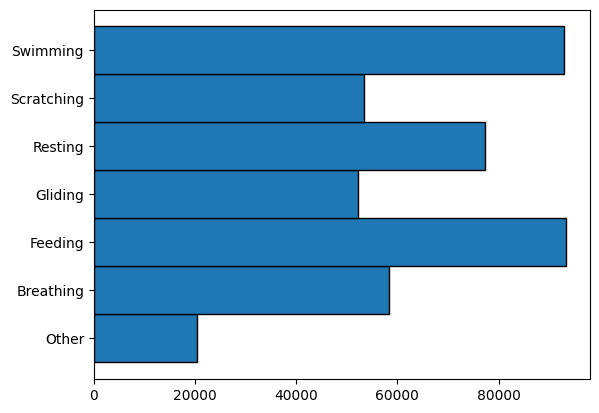

In [22]:
bins=np.arange(len(CLASSES)+1)-0.5
plt.hist(res,bins,edgecolor="k",orientation='horizontal');
xtics=range(len(CLASSES))
xtics_label=[CLASS.name for CLASS in CLASSES]
plt.yticks(xtics,xtics_label);


# Load the pre-trained U-net

In [23]:
#Parameters

Folder_model="Model_weights/Human"
LR_initial=memo["Lr_initial"]=0.0001
BATCH_SIZE=memo["batch_size"]=32
NB_OUTPUT=len(CLASSES)


In [24]:

def load_model(folder):

    # load json and create model
    json_file = open(folder+"/model.json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(folder+"/model.h5")
    return loaded_model


In [ ]:
model=load_model(Folder_model)


In [26]:
model.summary()

Model: "ZF_UNET_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 224, 6)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1, 224, 32)           608       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1, 224, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 1, 224, 32)           0         ['batch_normalizatio

## Add last layer

In [27]:
from keras.models import Model
from keras.layers import  Conv2D
from keras.layers import  Activation
from keras.optimizers import Adam 
from keras.callbacks import ReduceLROnPlateau

In [28]:
model.layers[82].name

'spatial_dropout2d'

In [29]:
nb_layer=len(model.layers)
for k in range(0,nb_layer):
    model.layers[k].trainable = True

In [30]:
#change the head of the model
ll = model.layers[82].output
ll = Conv2D(NB_OUTPUT, (1, 1), name="conv2d_turtle")(ll)
ll = Activation('softmax', name="activ_turtle")(ll)

new_model = Model(inputs=model.input,outputs=ll)

In [31]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 224, 6)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1, 224, 32)           608       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1, 224, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 1, 224, 32)           0         ['batch_normalization[0][0

## Compile the model

In [32]:
optim = Adam(learning_rate=LR_initial)
new_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                            factor=np.sqrt(0.1),
                            cooldown=0,
                            patience=10, min_lr=1e-12)
callbacks = [lr_reducer]

memo["function_loss"]="categorical_crossentropy"

# Training !

In [33]:
import time

class Trainer():

    def __init__(self,model):

        self.model_name=Folder_out+"/model.json"
        self.weights_name=Folder_out+"/model.h5"
        self.monitor="val_loss"

        # model
        self.model = model

        # training info
        self.history = None
        self.Nb_epochs = 10
        self.best_epoch = 0
        self.durations = []
        self.total_duration = 0
        self.loss_history = []
        self.val_loss_history = []
        self.acc_history = []
        self.val_acc_history = []
        #self.nb_models = 8

        # evaluation info
        self.score = None
        self.y_true = None
        self.y_pred = None


        self.best_epoch = 0
        self.best_value = 1e10
        self.best_epochs=[]
        self.best_values=[]

        self.epoch_count=-1



    def train(self, nb_additional_epochs, batch_size,train_gene, val_gene, learning_rate=None ,patience=1e10):

        if learning_rate is not None:
          tf.set_value(self.model.optimizer.lr, learning_rate)

        # early stopping initialization
        counter = 0

        # training epoch
        try:
            for k in range(nb_additional_epochs):

                self.epoch_count+=1


                if counter >= patience:
                    print("The model is not improving any more. Stopping the training process..")
                    break


                starting_time = time.time()

                # data generation
                print("new data generation")
                X_ep, Y_ep = next(train_gene)
                X_val_ep, Y_val_ep = next(val_gene)

                self.history = self.model.fit(
                    X_ep,
                    Y_ep,
                    batch_size=batch_size,
                    initial_epoch=self.epoch_count,
                    epochs=self.epoch_count+1,
                    validation_data=(X_val_ep,Y_val_ep)
                )


                # saving training epoch history
                duration=time.time()-starting_time
                self.durations.append(duration)
                self.total_duration+=duration

                self.loss_history.append(self.history.history["loss"][0])
                self.val_loss_history.append(self.history.history["val_loss"][0])
                self.acc_history.append(self.history.history["accuracy"][0])
                self.val_acc_history.append(self.history.history["val_accuracy"][0])

                current_value = self.history.history[self.monitor][0]


                if current_value < self.best_value:
                    print(self.monitor +  " improved from {:.5f} to {:.5f}".format(self.best_value, current_value))
                    self.best_value = current_value
                    self.best_epoch = self.epoch_count
                    self._save_model()
                    print("Model is saved on epoch {:d}.".format(self.best_epoch))
                    counter = 0
                    self.best_epochs.append(self.best_epoch)
                    self.best_values.append(self.best_value)

                else:
                    print(self.monitor + " did not improve.")
                    counter += 1


        except KeyboardInterrupt:
            print("\n Interuption volontaire")



    def _save_model(self):

        # serialize model to JSON
        model_json = self.model.to_json()
        with open(self.model_name, "w") as json_file:
              json_file.write(model_json)

        # serialize weights to HDF5
        self.model.save_weights(self.weights_name)



    def plot_training(self):

        print(self.monitor,":",self.best_epoch,self.best_value)
        print(self.best_epochs,self.best_values)



        fig,ax = plt.subplots(2,1 , figsize=(16, 10), sharex=True)

        # loss
        a=np.arange(len(self.loss_history))
        ax[0].plot(a,self.loss_history,label="loss")
        ax[0].plot(a,self.val_loss_history,label="val_loss")
        ax[0].legend()
        ax[0].set_title("Loss per epoch", color='coral', fontsize=16)

        if self.monitor == "val_loss":
            ax[0].plot(self.best_epochs,self.best_values,'o',label="best_loss")


        # accuracy
        ax[1].plot(a,self.acc_history,label="accuracy")
        ax[1].plot(a,self.val_acc_history,label="val_accuracy")
        ax[1].legend()
        ax[1].set_title("Accuracy per epoch", color='coral', fontsize=16)
        if self.monitor == "val_accuracy":
            ax[1].plot(self.best_epochs,self.best_values,'o',label="best_acc")

        ax[1].set_xlabel("epoch")

        fig.savefig(Folder_out+"/loss_acc_per_epoch.png")

In [34]:
memo["nb_train_per_epoch"]=6000
train_gen=oneEpoch_generator_window(NAMES_TRAIN,size = memo["nb_train_per_epoch"])

X,Y=next(train_gen)
X.shape,Y.shape

[('Other', 0.14285714285714285), ('Breathing', 0.14285714285714285), ('Feeding', 0.14285714285714285), ('Gliding', 0.14285714285714285), ('Resting', 0.14285714285714285), ('Scratching', 0.14285714285714285), ('Swimming', 0.14285714285714285)]


the class to promote:Other is not present in:CC-09-80_08-03-2023_1
the class to promote:Resting is not present in:CC-09-80_08-03-2023_2
the class to promote:Resting is not present in:CC-09-80_16-05-2023_2
the class to promote:Scratching is not present in:CC-09-80_16-05-2023_2


((6000, 1, 224, 6), (6000, 1, 224, 7))

In [35]:
memo["nb_val_per_epoch"]=3000
valid_gen=oneEpoch_generator_window(NAMES_VAL,size = memo["nb_val_per_epoch"])

X_val,Y_val=next(valid_gen)
X_val.shape,Y_val.shape

[('Other', 0.14285714285714285), ('Breathing', 0.14285714285714285), ('Feeding', 0.14285714285714285), ('Gliding', 0.14285714285714285), ('Resting', 0.14285714285714285), ('Scratching', 0.14285714285714285), ('Swimming', 0.14285714285714285)]
the class to promote:Other is not present in:CC-09-72_01-02-2023_1
the class to promote:Resting is not present in:CC-09-72_01-02-2023_2
the class to promote:Scratching is not present in:CC-09-72_01-02-2023_2


((3000, 1, 224, 6), (3000, 1, 224, 7))

In [36]:
trainer=Trainer(new_model)

In [ ]:
trainer.train(20 ,BATCH_SIZE,train_gen,valid_gen)

val_loss : 10 0.9335934519767761
[0, 1, 2, 3, 4, 5, 6, 10] [1.5328447818756104, 1.3027724027633667, 1.1748062372207642, 1.1522209644317627, 1.0978673696517944, 1.0652647018432617, 0.9640796780586243, 0.9335934519767761]


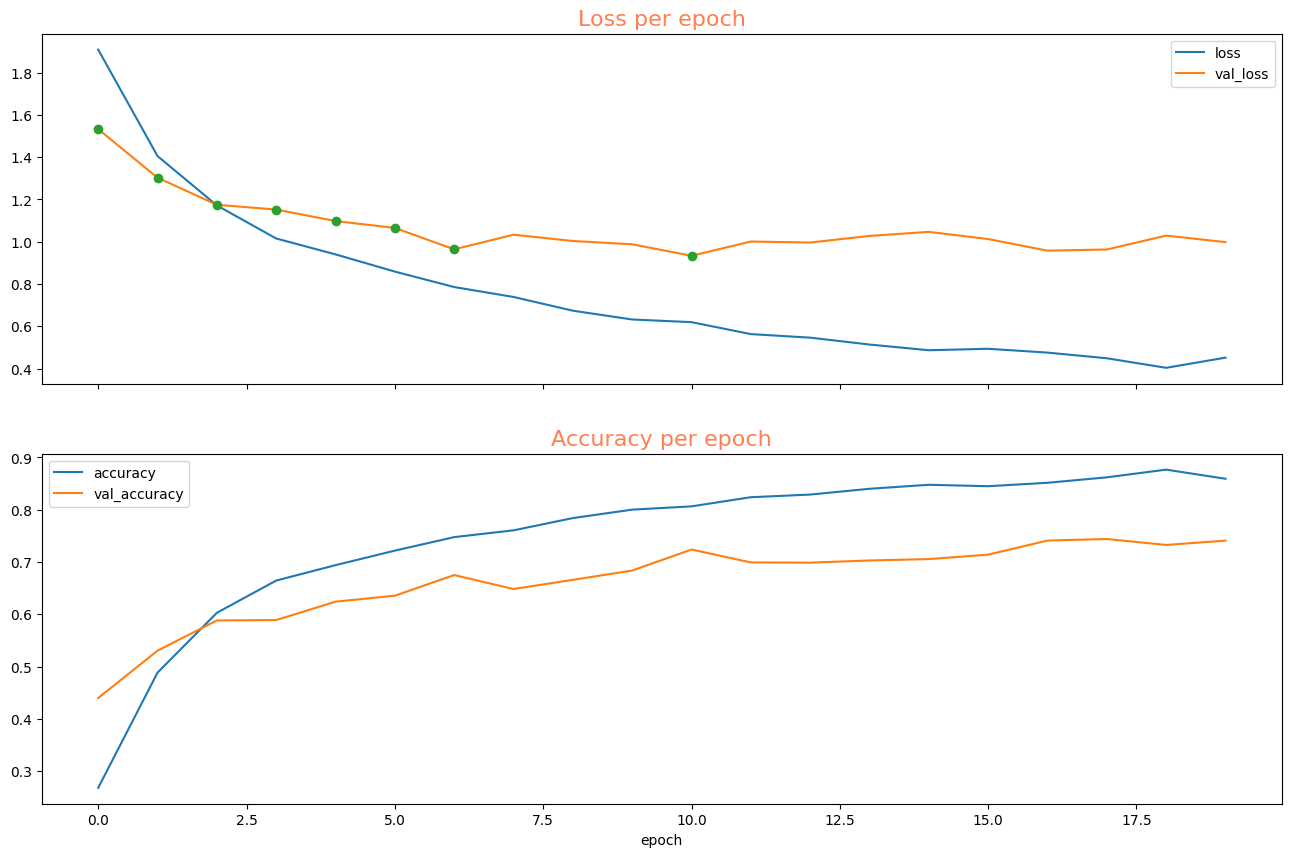

In [ ]:
trainer.plot_training()

In [ ]:
print("Training took {:.2f} seconds".format(trainer.total_duration))
print("Which is {:.2f} minutes".format(trainer.total_duration/60))

Training took 553.49 seconds
Which is 9.22 minutes


In [ ]:
print(trainer.__dict__)
memo["trainer"]=trainer.__dict__
memo["trainer.epoch_count"]=trainer.epoch_count
memo["trainer.best_epoch"]=trainer.best_epoch
memo["trainer.best_value"]=trainer.best_value
memo["trainer.total_duration"]=trainer.total_duration

In [ ]:
#save the memo and the parameters of the model
memo.to_csv(Folder_out+"/memo.csv")

# Testing


In [ ]:
Folder_out

In [ ]:
#load the last model saved 
model=load_model(Folder_out)

In [ ]:
def cut_full_slice(matrix,label, window_size):

    margin=int(0.1*window_size)
    stride=window_size-2*margin

    size=len(matrix)//stride-1
    nb_input=matrix.shape[1]

    X= np.empty([size,window_size,nb_input])
    Y= np.empty([size,window_size],dtype=int)

    for i in range(size):
        t=i*stride
        X[i,:,:]=matrix[t:t+window_size ,:]
        Y[i]=label[t:t+window_size]

    return X, Y



def stick(Y):

    window_size=Y.shape[1]
    margin=int(0.1*window_size)

    res=[]
    res.append(Y[0,:window_size-margin])

    for i in range(1,len(Y)):
        res.append(Y[i,margin:-margin])

    return np.concatenate(res,axis=0)


## PLot / Comparaison

In [ ]:
def get_all(turtle_names, matrices, labels, window_size, dir_out, Save=True):

    all_pred={}
    all_true={}

    for i,name in enumerate(turtle_names):
        matrix=matrices[name]
        label=labels[name]
        print(name,matrix.shape,label.shape)

        X_cut,Y_cut=cut_full_slice(matrix, label, window_size)
        Y_true=stick(Y_cut)
        all_true[name]=Y_true


        #prediction
        Y_cut_pred_proba=new_model.predict([X_cut.reshape(-1,1,X_cut.shape[1] ,X_cut.shape[2])])
        Y_cut_pred_proba=Y_cut_pred_proba.reshape(Y_cut_pred_proba.shape[0], Y_cut_pred_proba.shape[2], -1)
        Y_cut_pred=np.argmax(Y_cut_pred_proba,axis=2)

        Y_pred=stick(Y_cut_pred)
        Y_pred_proba=stick(Y_cut_pred_proba)

        if Save== True :
          np.save(dir_out+"/"+name+"=Y_pred",Y_pred)
          np.save(dir_out+"/"+name+"=Y_pred_proba",Y_pred_proba)
          np.save(dir_out+"/"+name+"=Y_true",Y_true)

        all_pred[name]=Y_pred

    return all_pred,all_true

In [ ]:
all_pred,all_true=get_all(NAMES_ALL, Matrices, Labels, WINDOW_SIZE, Folder_out)

CC-09-80_08-03-2023_1 (531000, 6) (531000,)
93/93 [==============================] - 5s 49ms/step
CC-09-80_08-03-2023_2 (420299, 6) (420299,)
73/73 [==============================] - 3s 47ms/step
CC-09-72_02-11-2022_1 (685601, 6) (685601,)
119/119 [==============================] - 5s 43ms/step
CC-09-80_16-05-2023_1 (480267, 6) (480267,)
84/84 [==============================] - 4s 45ms/step
CC-09-80_16-05-2023_2 (232536, 6) (232536,)
41/41 [==============================] - 2s 36ms/step
CC-09-72_01-02-2023_1 (615327, 6) (615327,)
107/107 [==============================] - 4s 36ms/step
CC-09-72_01-02-2023_2 (663280, 6) (663280,)
116/116 [==============================] - 4s 37ms/step
CC-09-80_28-03-2023_1 (515456, 6) (515456,)
90/90 [==============================] - 3s 38ms/step
CC-09-80_28-03-2023_2 (429822, 6) (429822,)
75/75 [==============================] - 3s 36ms/step
CC-09-80_01-02-2023_1 (454996, 6) (454996,)
79/79 [==============================] - 3s 37ms/step


In [ ]:
def plot_categorical_vector(ax,vector,cat_selected,cat_names,markersize=2,color=None,label=None):

    #listes des couleurs par défaut
    #colors=plt.rcParams['axes.prop_cycle'].by_key()['color']

    for cat in cat_selected:
        ax.set_label("toto")
        here=(vector==cat)
        x_here=np.arange(len(vector))[here]
        y_here=cat*np.ones(len(vector))[here]
        line,=ax.plot(x_here, y_here,'o',markersize=markersize,color=color)


    line.set_label(label)

    ax.set_yticks(range(len(cat_selected)))
    ax.tick_params(colors='coral')
    labels=[]
    for cat in cat_selected:
        labels.append(str(cat)+":"+cat_names[cat])

    ax.set_yticklabels(labels)

In [ ]:
def plot_compa_Y(ax,y,y_pred):

    nb_output=len(CLASSES)
    class_names=[CLASS.name for CLASS in CLASSES]


    plot_categorical_vector(ax,y,range(nb_output),class_names,markersize=3,color="blue",label="Y")
    plot_categorical_vector(ax,y_pred,range(nb_output),class_names,markersize=1,color="red",label="Y_pred")

    ax.legend()


In [ ]:
def plot_compa(turtle_names,title,deb=0,fin=-1):
    #deb=0
    #fin=-1
    nb=len(turtle_names)
    fig,axs=plt.subplots(nb,1,figsize=(12,2*nb),sharex=False)
    if nb==1:axs=[axs]

    for i,name in enumerate(turtle_names):
        plot_compa_Y(axs[i],all_true[name][deb:fin],all_pred[name][deb:fin])
        axs[i].set_title(name, color="coral", fontsize=16)

    fig.tight_layout()

    fig.savefig(Folder_out+"/"+title+".png")

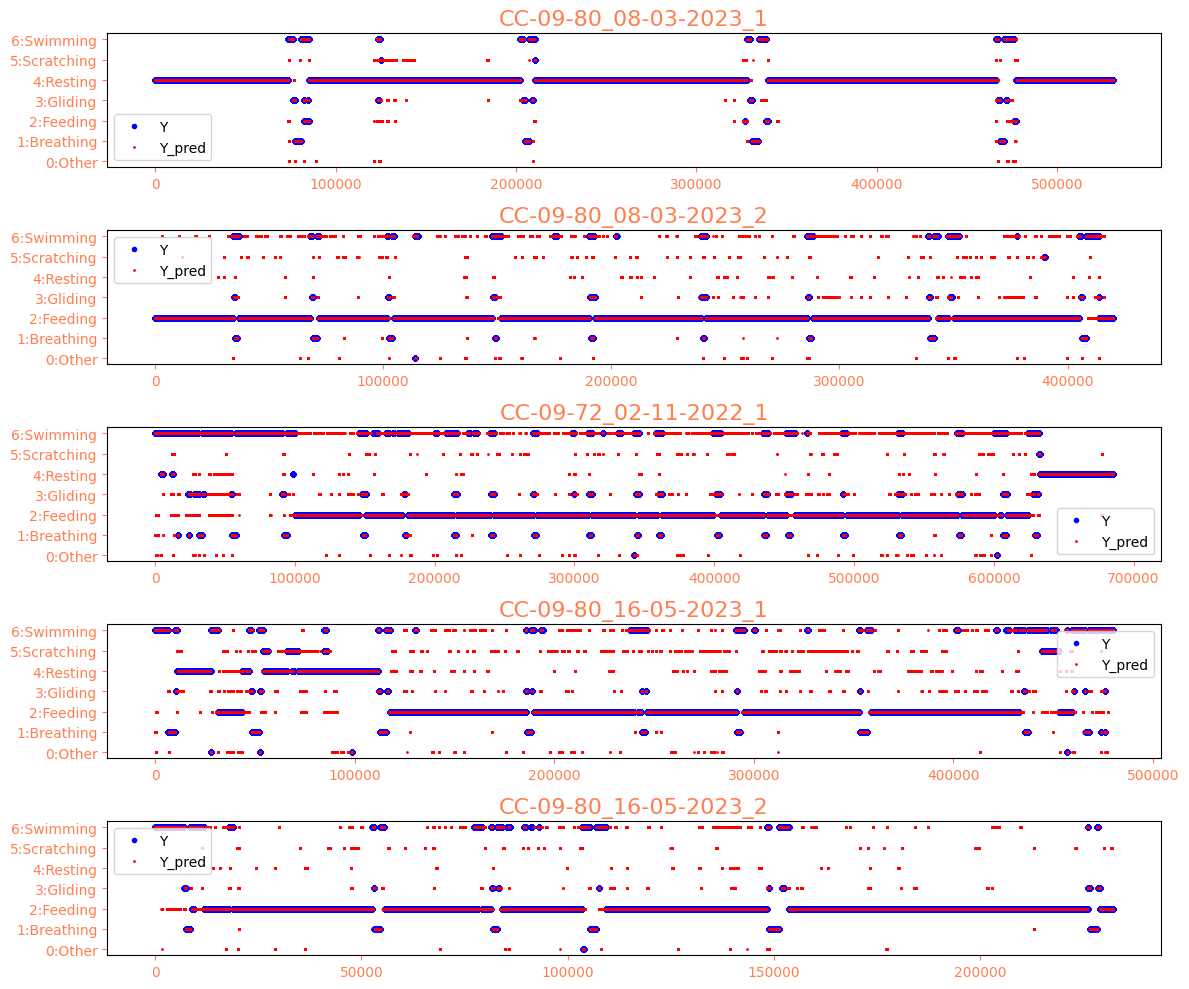

In [ ]:
plot_compa(NAMES_TRAIN,"compa on train")

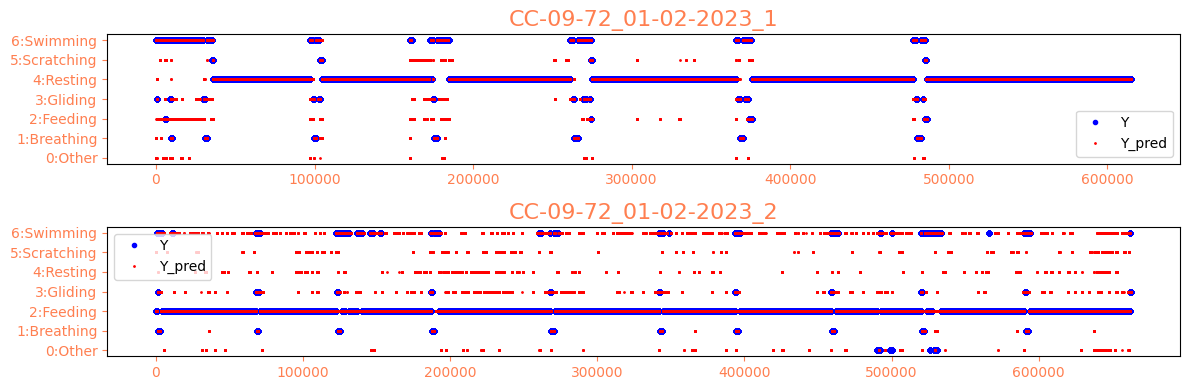

In [ ]:
plot_compa(NAMES_VAL,"compa on val")

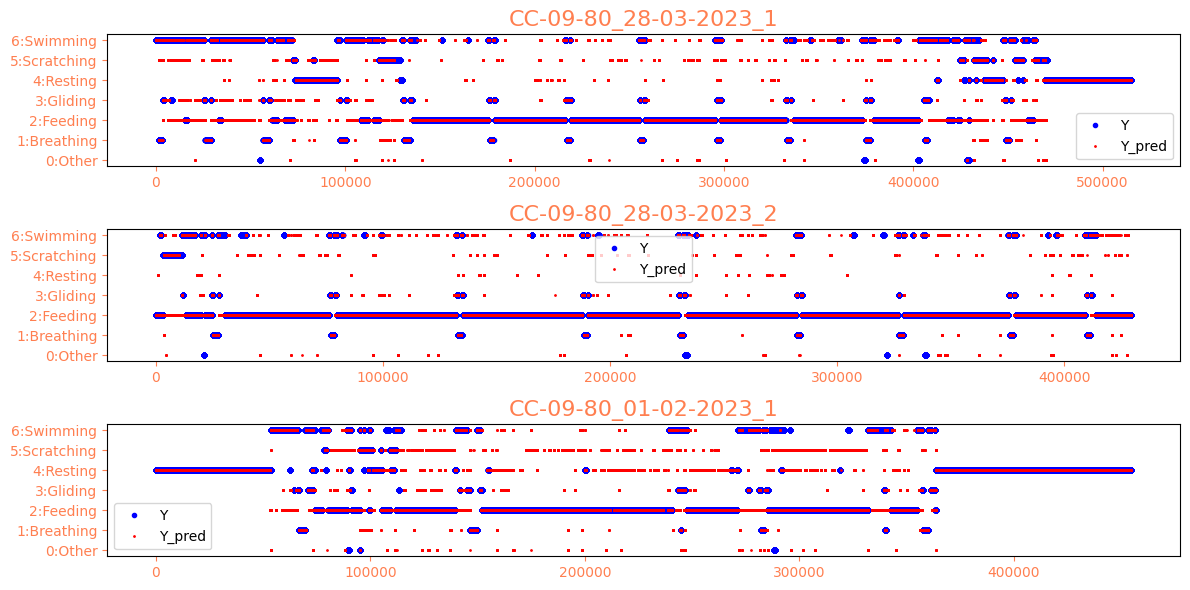

In [ ]:
plot_compa(NAMES_TEST,"compa on test")

## Confusion Matrix


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize,
                          title,
                          cmap="jet",
                          precision=2,
                         ):


    y_true=y_true.astype(int)
    y_pred=y_pred.astype(int)

    np.set_printoptions(precision=precision)


    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    print("Confusion matrix, without normalization:")
    print(cm)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        print(cm)


    fig, ax = plt.subplots(figsize=(12,12))
    ax.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.'+str(precision)+'f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "coral")
    fig.tight_layout()
    fig.savefig(Folder_out+"/"+title)



Confusion matrix, without normalization:
[[    11     10   2676      7      0    157    356]
 [    17  48728      0    111     29     61    375]
 [   936    363 760367   4478  38254  31264  11824]
 [    87    891   6363  15766    964   1467   1680]
 [     0      1   6194   1517 218309   6932     17]
 [   166   2995  18208    328    800  19182   1125]
 [   188    822  92172   7154    547   3946  91541]]
Normalized confusion matrix
[[3.42e-03 3.11e-03 8.32e-01 2.18e-03 0.00e+00 4.88e-02 1.11e-01]
 [3.45e-04 9.88e-01 0.00e+00 2.25e-03 5.88e-04 1.24e-03 7.60e-03]
 [1.10e-03 4.28e-04 8.97e-01 5.28e-03 4.51e-02 3.69e-02 1.40e-02]
 [3.20e-03 3.27e-02 2.34e-01 5.79e-01 3.54e-02 5.39e-02 6.17e-02]
 [0.00e+00 4.29e-06 2.66e-02 6.51e-03 9.37e-01 2.98e-02 7.30e-05]
 [3.88e-03 7.00e-02 4.25e-01 7.66e-03 1.87e-02 4.48e-01 2.63e-02]
 [9.57e-04 4.19e-03 4.69e-01 3.64e-02 2.79e-03 2.01e-02 4.66e-01]]


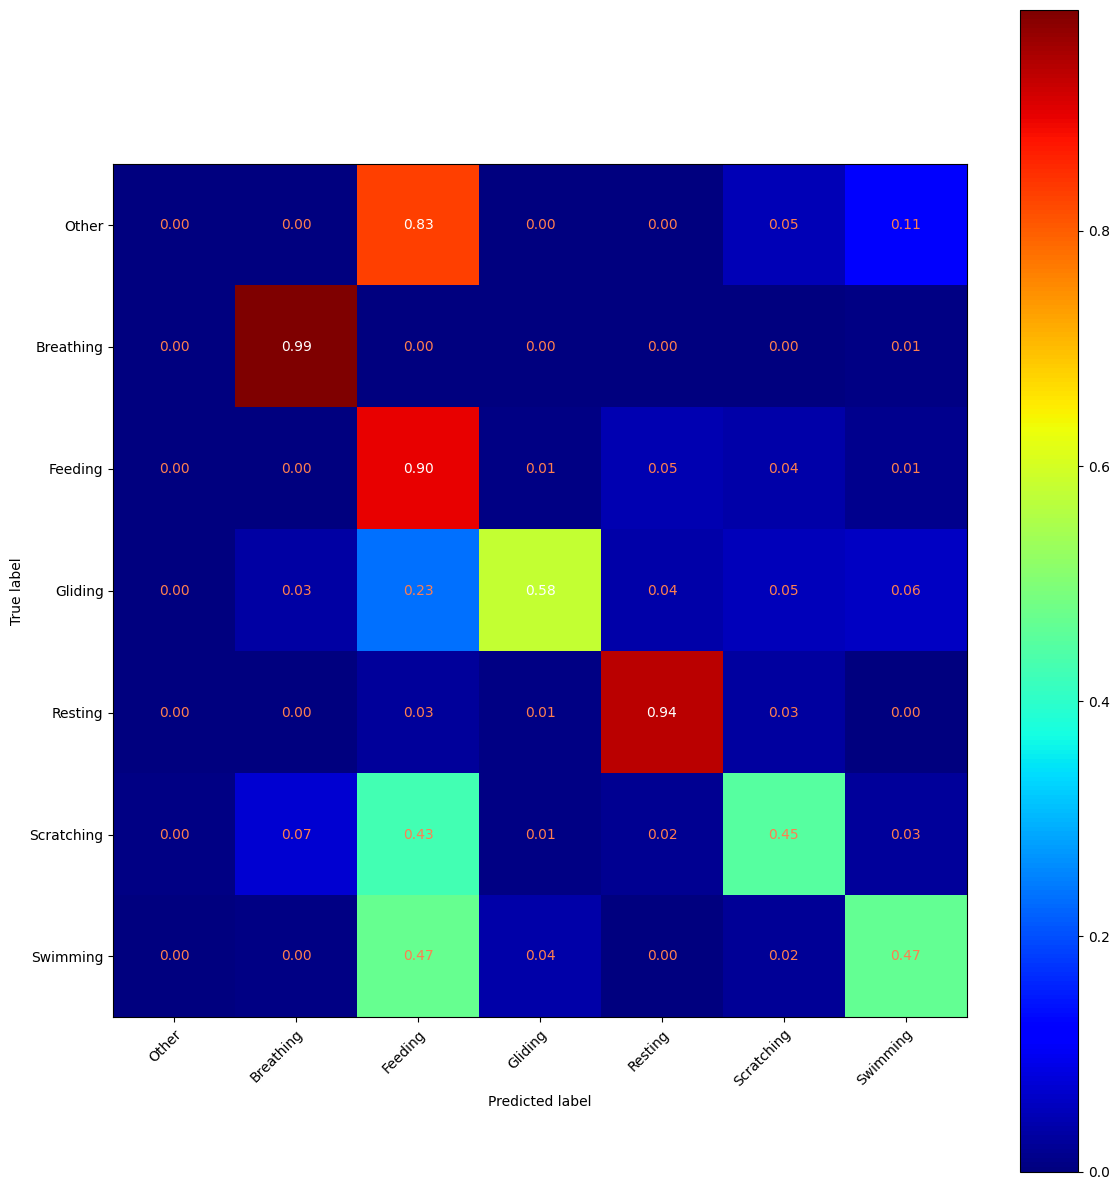

In [ ]:
#calculate the confusion matrix only on the testing dataset
whole_true=[]
whole_pred=[]
for name in NAMES_TEST:
    whole_true.append(all_true[name])
    whole_pred.append(all_pred[name])

whole_true=np.concatenate(whole_true)
whole_pred=np.concatenate(whole_pred)
class_names=[CLASS.name for CLASS in CLASSES]

plot_confusion_matrix(whole_true,whole_pred, np.array(class_names),True,"whole validation")


In [ ]:
#To calculate Precisionm Recall, Specificity and F1-score

cm = confusion_matrix(whole_true, whole_pred)

print(cm)
TP=np.diag(cm)
FP=np.sum(cm,axis=1)-TP
FN=np.sum(cm,axis=0)-TP
TN=np.ones(len(class_names))*np.sum(cm)-TP-FP-FN

Accuracy=(TP+TN)/(TP+TN+FP+FN)
Recall=TP/(TP+FN)
Precision =TP/(TP+FP)
Specificity =TN/(TN+FP)
F1_score=2*(Recall*Precision)/ (Recall+Precision)




[[    11     10   2676      7      0    157    356]
 [    17  48728      0    111     29     61    375]
 [   936    363 760367   4478  38254  31264  11824]
 [    87    891   6363  15766    964   1467   1680]
 [     0      1   6194   1517 218309   6932     17]
 [   166   2995  18208    328    800  19182   1125]
 [   188    822  92172   7154    547   3946  91541]]


In [ ]:
df = pd.DataFrame({'Accuracy': Accuracy, 'Recall': Recall, 'Precision': Precision, 'Specificity': Specificity,'F1_score': F1_score},
                      index = class_names)
df

,Accuracy,Recall,Precision,Specificity,F1_score
Other,0.996713,0.007829,0.003419,0.997707,0.004760
Breathing,0.995945,0.905557,0.987977,0.999559,0.944973
Feeding,0.847982,0.858221,0.897203,0.830312,0.877279
Gliding,0.982101,0.536971,0.579249,0.991641,0.557309
Resting,0.960515,0.843208,0.937069,0.987145,0.887664
Scratching,0.951801,0.304433,0.448136,0.982324,0.362564
Swimming,0.914101,0.856180,0.466166,0.918892,0.603657


In [ ]:
Global_accuracy=(np.sum(TP)+np.sum(TN))/(np.sum(TP)+np.sum(TN)+np.sum(FP)+np.sum(FN))
print("Global Accuracy :", Global_accuracy)

Global Accuracy : 0.9498796513001314


In [ ]:
F1_score=np.mean(df['F1_score'][~np.isnan(df['F1_score'])])
print("F1-score :", F1_score)

F1-score : 0.6054581246917005


In [ ]:
F1_score=np.mean(df['F1_score'][1:])
print("F1-score :", F1_score)

F1-score : 0.7055745047697705
